In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import vaemof
from vaemof import experiments
from vaemof import utils
from vaemof.vocabs import SELFIESVocab, MOFVocab, PropVocab
from vaemof import modules
from vaemof import training
from vaemof.model import VAEMOF
from vaemof import configs
from vaemof.utils import header_str
vaemof.experiments.plot_settings()

In [6]:
import os
import random
from tqdm.auto import tqdm
import numpy as np
import torch
import rdkit
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.decomposition import PCA
from itertools import product
from more_itertools import chunked
from collections import OrderedDict

print(f'rdkit : {rdkit.__version__}')
print(f'torch : {torch.__version__}')
print(f'cuda? {torch.cuda.is_available()}')
tqdm.pandas()
utils.disable_rdkit_log()

rdkit : 2019.09.3
torch : 1.4.0
cuda? True


## Hparams

In [7]:
preset = 'full'
WORK_DIR = 'results/best/'
hparams = configs.get_model_config(WORK_DIR, preset, rand=False)
print(utils.header_str(preset))
hparams['train_device'] = 'cuda' if torch.cuda.is_available() else 'cpu'

testing = configs.testing_config(hparams)
configs.print_config(hparams)
utils.set_seed(hparams['train_seed'])
device = torch.device(hparams['train_device'])

===================================== full =====================================
==================================== config ====================================
== train == :
        train_device:                cuda
          train_seed:                  42
    train_batch_size:                1536
        train_epochs:                  90
            train_lr:        0.0005705023
     train_clip_grad:                  20
== vae == :
      vae_latent_dim:                 288
           vae_y_dec:                True
     vae_selfies_dec:                True
         vae_mof_enc:                True
         vae_mof_dec:                True
vae_duplicate_smiles:                True
== mof == :
        mof_encoding:                cats
   mof_weighted_loss:                True
         mof_w_start:                 0.0
           mof_w_end:               0.001
           mof_start:                   0
    mof_const_length:                  10
== y == :
            y_labels:['lcd', 'pld'

## Load MOF data

Assemble smiles formula: [organic core][metal_node][topology][branch_smiles]

In [8]:
smiles_column = 'branch_smiles'
testtrain_column = 'train/test'
df = experiments.get_generator_df(csv_file=hparams['files_data'],
                                  smiles_column=smiles_column,
                                  use_duplicates=hparams['vae_duplicate_smiles'],
                                  testing=testing)
ids2mofs, mof2ids, mof_columns = experiments.get_mofdict(
    df, hparams['mof_encoding'])
df.head()

=================================== Real run ===================================
df shape: (2049964, 8)
df columns: ['branch_smiles', 'id2mof', 'metal_node', 'mof_index', 'organic_core', 'randomized', 'topology', 'train/test']
Found 713 unique mofs


branch_smiles  id2mof  metal_node  \
0  CC(c1cc(O)cc(O)c1)(C(Sc1cc(O)cc(O)c1)c1cc(O)cc...       0  sym_7_mc_4   
1  Oc1ccc(-c2cc(/C=C/c3c(-c4ccc(O)cc4)cc([Lr])c(-...       0  sym_7_mc_4   
2  O=S(=O)(O)Cc1nn([Lr])c(CS(=O)(=O)O)c1-c1c(CS(=...       0  sym_7_mc_4   
3  [Lr]c1ccc(-c2c(-c3ccccc3)cc([Lr])c(-c3ccccc3)c...       0  sym_7_mc_4   
4  [Lr]c1ccc(N2C=C(c3ccncc3)N(c3c(-c4ccncc4)cc([L...       0  sym_7_mc_4   

   mof_index organic_core  randomized topology  train/test  
0        4.0         None       False      acs           1  
1       10.0         None       False      acs           1  
2       18.0         None       False      acs           1  
3       23.0         None       False      acs           1  
4       29.0         None       False      acs           1

## Load property data

In [9]:
prop_df = experiments.get_prop_df(csv_file=hparams['files_prop'],
                                  targets=hparams['y_labels'],
                                  mof2ids=mof2ids,
                                  testing=testing,
                                  smiles_column=smiles_column,
                                  compute_scscore=True)
prop_df.head()

=================================== Real run ===================================
Restored variables from data/scscore_1024uint8_model.ckpt-10654.as_numpy.json.gz



Removed 2923 datapoints due to mask.
Removed 1819 datapoints due non-valid mof (mof2ids).
Removed 245 datapoints due to high selectivity.


organic_core  metal_node topology  \
0         None  sym_7_mc_4      acs   
1         None  sym_7_mc_4      acs   
2         None  sym_7_mc_4      acs   
3         None  sym_7_mc_4      acs   
4         None  sym_7_mc_4      acs   

                                       branch_smiles       lcd       pld  \
0  COc1c(/C=C/c2ccc([Lr])cc2)cc(OC)c(/C=C/c3ccc([...  24.87798  19.29733   
1         CSC1=C2CCC(=C(C(=C2SC)[Lr])SC)C(=C1[Lr])SC   7.78281   5.18969   
2   O=C(c1cc(O)c(cc1O)[Lr])OOC(=O)c1cc(O)c(cc1O)[Lr]  17.01677  15.91720   
3   Oc1c(cc(c(c1O)[Lr])O)c1nnc(nn1)c1ccc(c(c1)O)[Lr]  19.50569  17.17410   
4                        [Lr]C12C=CC(C=C1)(C=C2)[Lr]   9.58653   8.21739   

    density      avf      avsa      agsa  ...  co2ch4_selectivity  \
0  0.164554  0.75459  1159.130  7044.060  ...            1.786937   
1  1.119280  0.07631   978.891   874.575  ...            3.197185   
2  0.320703  0.61736  1628.620  5078.290  ...            3.004385   
3  0.291374  0.66206  1401.740  4810.800  ...            2.250807   
4  0.799733  0.24196  2020.860  2526.910  ...            2.167731   

   co2ch4_heat_avg  co2ch4_heat_co2  co2ch4_heat_ch4  co2ch4_heat_molfrac  \
0         -8.58733        -12.08169         -7.92879             -8.61737   
1        -20.54264        -24.18495        -18.74239            -20.17205   
2        -11.22187        -16.39748         -9.43473            -11.17660   
3         -9.49245        -13.39225         -8.37161             -9.37550   
4        -15.36924        -18.34929        -14.67475            -15.38911   

   selfies_safe  mask  train/test   scscore  id2mof  
0          True  True           1  3.384814       0  
1          True  True           0  3.176298       0  
2          True  True           1  2.668208       0  
3          True  True           1  3.688210       0  
4          True  True           1  1.831772       0  

[5 rows x 29 columns]

## Train/test splits and hparams

In [10]:
train_index = np.array(df[df[testtrain_column] == 1].index.tolist())
test_index = np.array(df[df[testtrain_column] == 0].index.tolist())
prop_train_index = np.array(
    prop_df[prop_df[testtrain_column] == 1].index.tolist())
prop_test_index = np.array(
    prop_df[prop_df[testtrain_column] == 0].index.tolist())
print(f'Train sizes: {len(train_index):7d} and {len(prop_train_index):7d}')
print(f'Test  sizes: {len(test_index):7d} and {len(prop_test_index):7d}')

Train sizes: 1894967 and   36795
Test  sizes:  154997 and    4107


# Vocabulary and preprocessors

In [11]:
smiles_list = df[smiles_column].tolist()+prop_df[smiles_column].tolist()
vocab = SELFIESVocab.from_data(smiles_list)
vocab_mof = MOFVocab.from_data(df.append(
    prop_df, sort=False), mof_columns, weighting=hparams['mof_weighted_loss'])
vocab_y = PropVocab.from_data(
    prop_df, hparams['y_labels'], hparams['y_weights'], hparams['scaler_type'])
vocab, vocab_mof, vocab_y


Alphabet size is 73
Max seq length is 109 with 5 extra padding
Used columns =['metal_node', 'organic_core', 'topology'] with frequency weighting=True
metal_node   has 15 classes
organic_core has 52 classes
topology     has 41 classes


(<vaemof.vocabs.SELFIESVocab at 0x7f5846231850>,
 <vaemof.vocabs.PropVocab at 0x7f593ace4b90>)

# Instanciate Model

## Careful! (it saves and will overwrite any model previously saved)

In [12]:
try:
    utils.clear_torch(model)
except:
    utils.clear_torch(model=None)

model = VAEMOF(hparams, vocab, vocab_mof, vocab_y).to(device)
model.save()
modules.model_summary(model, include_children=False)

Name       Module                                         Extra  \
0      z_mu       Linear  in_features=576, out_features=288, bias=True   
1  z_logvar       Linear  in_features=576, out_features=288, bias=True   
2     enc_x  CharEncoder                                                 
3     dec_x  CharDecoder                                                 
4   enc_mof   MOFEncoder                                                 
5   dec_mof   MOFDecoder                                                 
6     dec_y  PropDecoder                                                 

   submodule  trainable  n_params  trainable_params  
0      False       True    166176            166176  
1      False       True    166176            166176  
2      False       True   2388096           2388096  
3      False       True   2510792           2510792  
4      False       True    280800            280800  
5      False       True    114552            114444  
6      False       True      6090              6069

Trainable params: 5627369 out of 5627498 total (100.00%)


## Prepare train/test 

In [13]:
train_mof = model.df_to_tuples(df.loc[train_index], smiles_column)
test_mof = model.df_to_tuples(df.loc[test_index], smiles_column)
prop_train = model.df_to_tuples(prop_df.loc[prop_train_index], smiles_column)
prop_test = model.df_to_tuples(prop_df.loc[prop_test_index], smiles_column)
train_data = train_mof + prop_train
test_data = test_mof + prop_test

## Train

In [15]:
trainer = training.Trainer(hparams)
trainer.train(model, train_data, test_data)

In [16]:
hparams_file = os.path.join(WORK_DIR,'config.json')
hparams = configs.AttributeDict.from_jsonfile(hparams_file)
configs.print_config(hparams)
model = VAEMOF.load(hparams)
test_mof = model.df_to_tuples(df.loc[test_index], smiles_column)
prop_test = model.df_to_tuples(prop_df.loc[prop_test_index], smiles_column)
len(test_mof), len(prop_test)

==================================== config ====================================
== train == :
        train_device:                cuda
          train_seed:                  42
    train_batch_size:                1536
        train_epochs:                  90
            train_lr:0.0005705023000000001
     train_clip_grad:                  20
== vae == :
      vae_latent_dim:                 288
           vae_y_dec:                True
     vae_selfies_dec:                True
         vae_mof_enc:                True
         vae_mof_dec:                True
vae_duplicate_smiles:                True
== mof == :
        mof_encoding:                cats
   mof_weighted_loss:                True
         mof_w_start:                 0.0
           mof_w_end:               0.001
           mof_start:                   0
    mof_const_length:                  10
== y == :
            y_labels:['lcd', 'pld', 'density', 'avf', 'avsa', 'agsa', 'co2n2_co2_mol_kg', 'co2n2_n2_mol_kg', 'co2n

(154997, 4107)

## Training stats

In [17]:
log_df = pd.read_csv(configs.at_results_dir(hparams,'files_log'))
print(log_df.shape)
print(log_df.columns)
log_df.head()

(90, 69)
Index(['epoch', 'test_kl', 'test_x', 'test_mof', 'test_y', 'test_loss',
       'lcd-r2', 'lcd-MAE', 'pld-r2', 'pld-MAE', 'density-r2', 'density-MAE',
       'avf-r2', 'avf-MAE', 'avsa-r2', 'avsa-MAE', 'agsa-r2', 'agsa-MAE',
       'co2n2_co2_mol_kg-r2', 'co2n2_co2_mol_kg-MAE', 'co2n2_n2_mol_kg-r2',
       'co2n2_n2_mol_kg-MAE', 'co2n2_selectivity-r2', 'co2n2_selectivity-MAE',
       'co2n2_heat_avg-r2', 'co2n2_heat_avg-MAE', 'co2n2_heat_co2-r2',
       'co2n2_heat_co2-MAE', 'co2n2_heat_n2-r2', 'co2n2_heat_n2-MAE',
       'co2n2_heat_molfrac-r2', 'co2n2_heat_molfrac-MAE',
       'co2ch4_co2_mol_kg-r2', 'co2ch4_co2_mol_kg-MAE', 'co2ch4_ch4_mol_kg-r2',
       'co2ch4_ch4_mol_kg-MAE', 'co2ch4_selectivity-r2',
       'co2ch4_selectivity-MAE', 'co2ch4_heat_avg-r2', 'co2ch4_heat_avg-MAE',
       'co2ch4_heat_co2-r2', 'co2ch4_heat_co2-MAE', 'co2ch4_heat_ch4-r2',
       'co2ch4_heat_ch4-MAE', 'co2ch4_heat_molfrac-r2',
       'co2ch4_heat_molfrac-MAE', 'scscore-r2', 'scscore-MAE', 'lr',

epoch     test_kl    test_x   test_mof    test_y  test_loss    lcd-r2  \
0      0  912.648813  0.451462  10.529093  1.843436   0.460589  0.906155   
1      1  276.613159  0.217422   6.070345  0.461664   0.272185  0.986669   
2      2  155.777572  0.119784   6.311328  0.451238   0.180457  0.987146   
3      3  110.457376  0.082680   6.734319  0.429072   0.147153  0.990065   
4      4   92.115217  0.059337   7.265631  0.422235   0.131124  0.993012   

      lcd-MAE    pld-r2    pld-MAE  ...    mof_acc   mean_r2  train_kl_ratio  \
0  112.079674  0.975873  49.082306  ...   3.748911  0.509237        0.008547   
1   46.877434  0.996405  14.961312  ...  34.652596  0.779580        0.153861   
2   45.208916  0.925927  60.363281  ...  30.429363  0.791782        0.248288   
3   39.073349  0.982350  33.022678  ...  25.923086  0.786539        0.326533   
4   33.789803  0.997410  15.315241  ...  21.429799  0.848538        0.376332   

   train_x_ratio  train_mof_ratio  train_y_ratio  test_kl_ratio  test_x_ratio  \
0       0.991453         0.000000       0.000000       0.019815      0.980185   
1       0.807656         0.000205       0.038278       0.198797      0.798804   
2       0.654185         0.000586       0.096941       0.329092      0.663783   
3       0.491545         0.001179       0.180743       0.425489      0.561861   
4       0.363076         0.001834       0.258758       0.528604      0.452524   

   test_mof_ratio  test_y_ratio  
0        0.000000      0.000000  
1        0.000279      0.002120  
2        0.000874      0.006251  
3        0.001716      0.010934  
4        0.002771      0.016101  

[5 rows x 69 columns]

epoch     test_kl    test_x   test_mof    test_y  test_loss    lcd-r2  \
0      0  912.648813  0.451462  10.529093  1.843436   0.460589  0.906155   
1      1  276.613159  0.217422   6.070345  0.461664   0.272185  0.986669   

      lcd-MAE    pld-r2    pld-MAE  ...    mof_acc   mean_r2  train_kl_ratio  \
0  112.079674  0.975873  49.082306  ...   3.748911  0.509237        0.008547   
1   46.877434  0.996405  14.961312  ...  34.652596  0.779580        0.153861   

   train_x_ratio  train_mof_ratio  train_y_ratio  test_kl_ratio  test_x_ratio  \
0       0.991453         0.000000       0.000000       0.019815      0.980185   
1       0.807656         0.000205       0.038278       0.198797      0.798804   

   test_mof_ratio  test_y_ratio  
0        0.000000       0.00000  
1        0.000279       0.00212  

[2 rows x 69 columns]

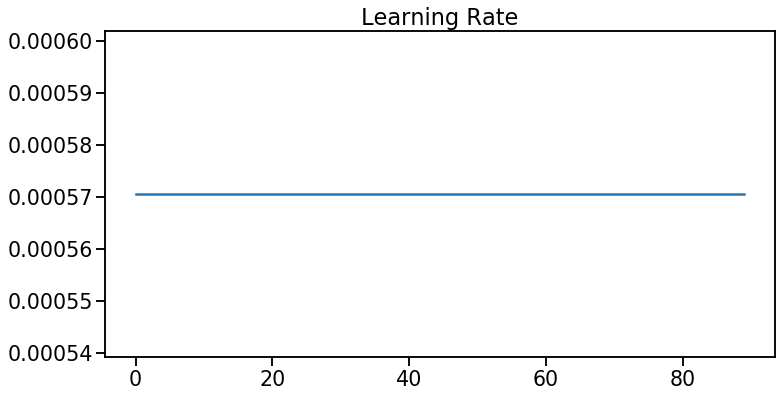

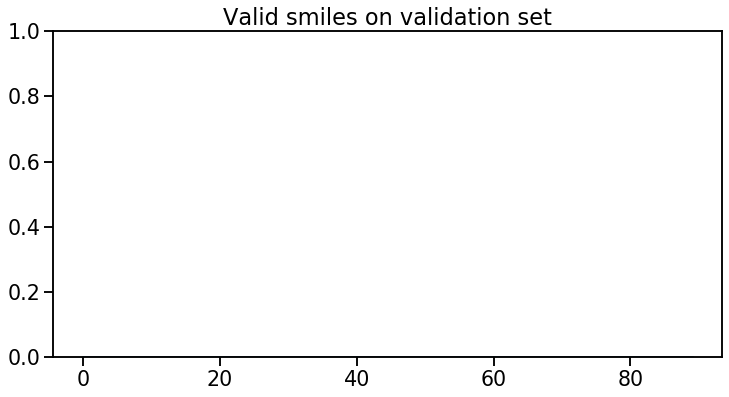

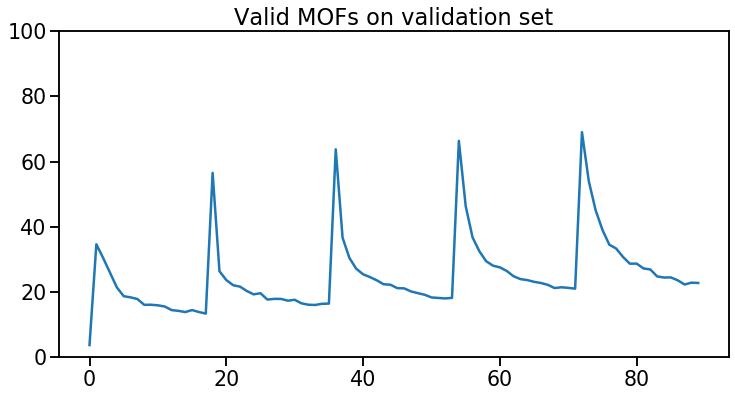

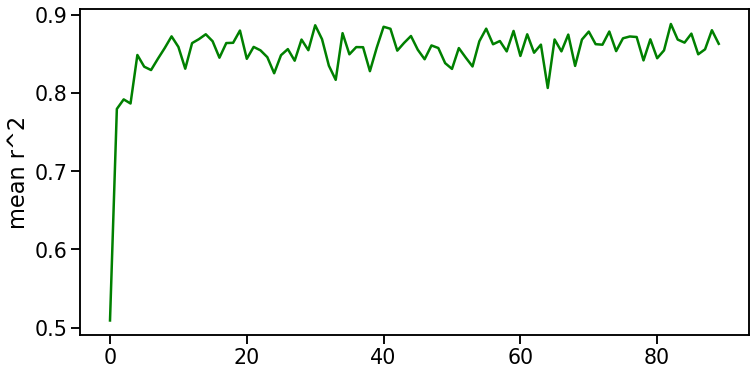

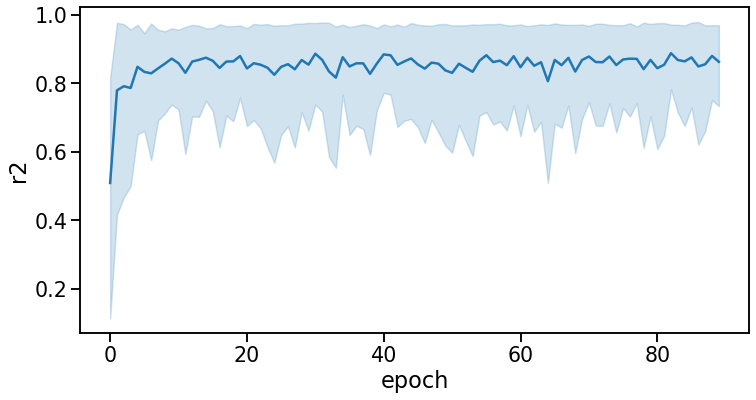

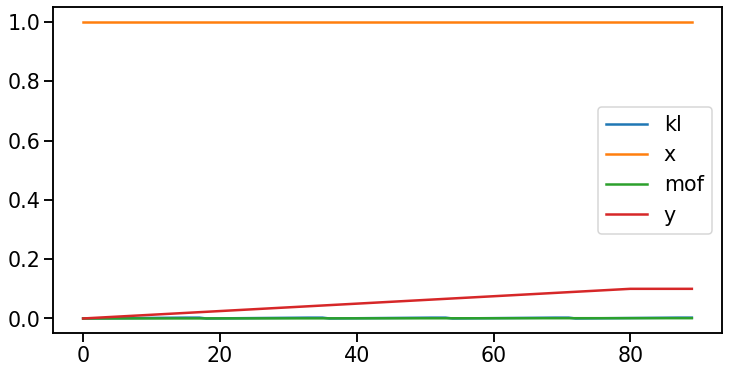

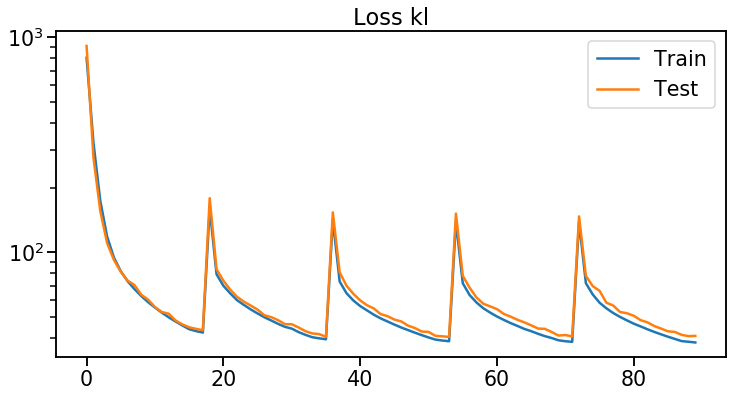

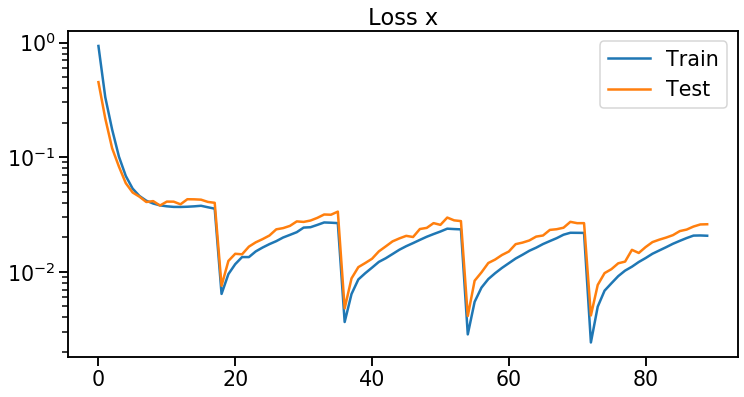

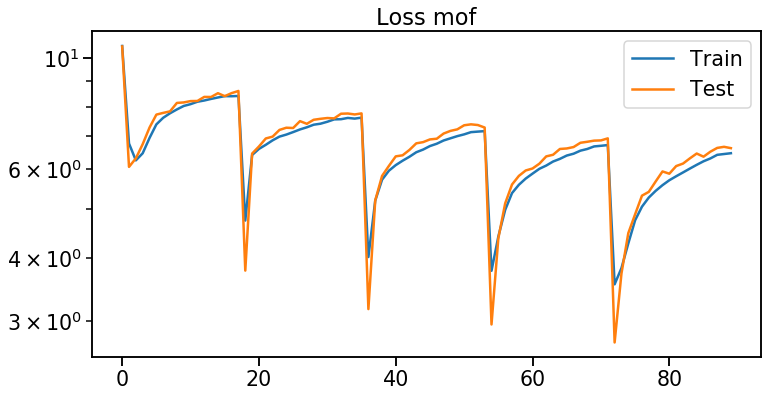

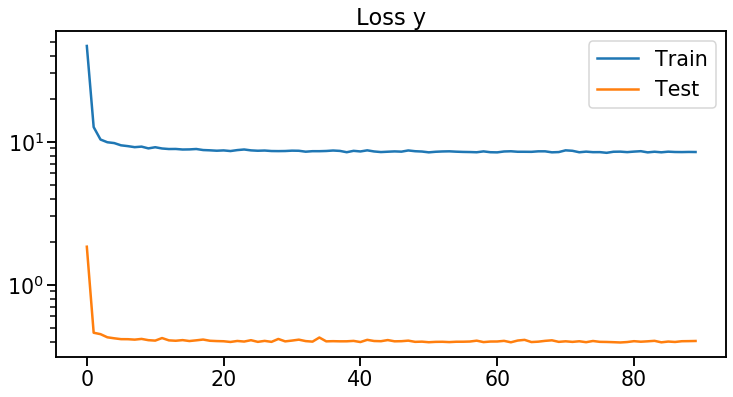

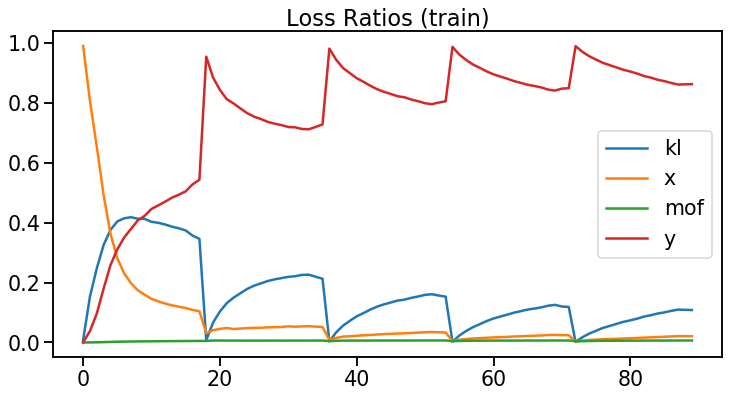

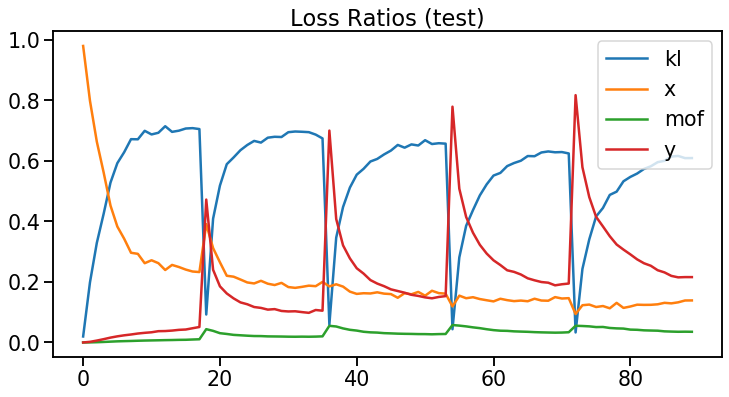

In [18]:
COMPONENTS = training.COMPONENTS
epochs = log_df['epoch'].values

display(log_df.head(2))
plt.plot(epochs, log_df['lr'])
plt.title('Learning Rate')
plt.show()

plt.plot(epochs, log_df['valid_smiles'])
plt.title('Valid smiles on validation set')
plt.ylim([0,1])
plt.show()

plt.plot(epochs, log_df['mof_acc'])
plt.title('Valid MOFs on validation set')
plt.ylim([0,100])
plt.show()

plt.plot(epochs, log_df['mean_r2'],c='g',label='valid')
plt.ylabel('mean r^2')
plt.show()

results=[]
for label in hparams['y_labels']:
    metric = f'{label}-r2'
    results.extend([{'epoch':epoch,'r2':value,"prop":label} for epoch, value in log_df[['epoch',metric]].values ]  )
prop_df = pd.DataFrame(results)
sns.lineplot(x='epoch',y='r2', data=prop_df)
plt.show()

for label in COMPONENTS:
    plt.plot(epochs, log_df[f'λ_{label}'], label =label)
plt.legend()
plt.show()

for label in COMPONENTS:
    plt.plot(epochs, log_df[f'train_{label}'], label='Train')
    plt.plot(epochs, log_df[f'test_{label}'], label='Test')
    plt.title(f'Loss {label}')
    plt.yscale("log")
    plt.legend()
    plt.show()

for prefix in ['train','test']:
    for label in COMPONENTS:
        plt.plot(epochs, log_df[f'{prefix}_{label}_ratio'], label=label) 
    plt.title(f'Loss Ratios ({prefix})')
    plt.legend()
    plt.show()

In [19]:
print(header_str('R^2 scores and MAEs'))
src_data = prop_test
batch_size = 256
n_loops = int(np.ceil(len(src_data) / batch_size))
y_pred, y_true = [], []
for chunk in  tqdm(chunked(src_data,batch_size),total=n_loops, desc='Pred'):
    batch = model.tuples_to_tensors(chunk)
    z = model.inputs_to_z(batch['x'],batch['mof'])
    outs = model.z_to_outputs(z)
    y_true.extend(model.vocab_y.inverse_transform(batch['y']))
    y_pred.extend(outs['y'])
    
y_pred = np.stack(y_pred)
y_true = np.stack(y_true)
experiments.regression_statistics(y_true, y_pred, hparams['y_labels'])

============================= R^2 scores and MAEs ==============================



lcd , R2:  0.8964897281942359 , MAE:  2.8463967 , RMSE:  4.3078084
pld , R2:  0.8870271669404939 , MAE:  2.6707072 , RMSE:  4.0994163
density , R2:  0.814988793384879 , MAE:  0.07900183 , RMSE:  0.11789168
avf , R2:  0.8819538143679002 , MAE:  0.04919533 , RMSE:  0.074545495
avsa , R2:  0.5792672603969335 , MAE:  200.99449 , RMSE:  344.5784
agsa , R2:  0.8778196773056047 , MAE:  392.45856 , RMSE:  612.2991
co2n2_co2_mol_kg , R2:  0.2032678737856729 , MAE:  0.0939981 , RMSE:  0.2185478
co2n2_n2_mol_kg , R2:  0.8243338173894965 , MAE:  0.041763924 , RMSE:  0.065448776
co2n2_selectivity , R2:  0.2981423923313634 , MAE:  2.052498 , RMSE:  4.8195662
co2n2_heat_avg , R2:  0.5161112634805768 , MAE:  1.9774332 , RMSE:  3.5009685
co2n2_heat_co2 , R2:  0.49634419060554047 , MAE:  2.181653 , RMSE:  3.8266792
co2n2_heat_n2 , R2:  0.4822739052771967 , MAE:  0.9972303 , RMSE:  1.9707711
co2n2_heat_molfrac , R2:  0.515107196076886 , MAE:  2.0390363 , RMSE:  3.567133
co2ch4_co2_mol_kg , R2:  0.246335

label        R2         MAE        RMSE
0                   lcd  0.896490    2.846397    4.307808
1                   pld  0.887027    2.670707    4.099416
2               density  0.814989    0.079002    0.117892
3                   avf  0.881954    0.049195    0.074545
4                  avsa  0.579267  200.994492  344.578400
5                  agsa  0.877820  392.458557  612.299072
6      co2n2_co2_mol_kg  0.203268    0.093998    0.218548
7       co2n2_n2_mol_kg  0.824334    0.041764    0.065449
8     co2n2_selectivity  0.298142    2.052498    4.819566
9        co2n2_heat_avg  0.516111    1.977433    3.500968
10       co2n2_heat_co2  0.496344    2.181653    3.826679
11        co2n2_heat_n2  0.482274    0.997230    1.970771
12   co2n2_heat_molfrac  0.515107    2.039036    3.567133
13    co2ch4_co2_mol_kg  0.246335    0.195238    0.371208
14    co2ch4_ch4_mol_kg  0.611755    0.352908    0.563521
15   co2ch4_selectivity  0.337300    0.530232    1.061806
16      co2ch4_heat_avg  0.488652    1.438150    2.981762
17      co2ch4_heat_co2  0.479845    1.822242    3.594280
18      co2ch4_heat_ch4  0.489870    1.189713    2.510879
19  co2ch4_heat_molfrac  0.489001    1.449088    2.959458
20              scscore  0.997557    0.031502    0.040327

## Prior check

In [39]:
print(header_str('prior'))
n = 10000
gen_df = experiments.sample_model(model, n)
print('valid smiles: {} out of {} ({}%)'.format(gen_df['valid'].sum(),n,gen_df['valid'].sum()/n*100.0))
gen_df.head(2)

==================================== prior =====================================



valid smiles: 6115 out of 10000 (61.150000000000006%)


branch_smiles  valid    metal_node  \
0  NCc1ccc([Lr])cc1C#Cc1cc(CN)c(CN)c(CN)c1C(CN)c1...   True    sym_6_mc_3   
1  PC=C([Lr])CC(P)(P)C1=CC(c2[nH]c([Lr])c(P)c2P)=C1P   True  sym_24_mc_13   

     organic_core topology        lcd        pld   density       avf  \
0   sym_4_vae_645      pcu   0.568714  -1.349203  0.566411  0.468299   
1  sym_3_vae_1168      rht  28.705706  11.637435  0.298795  0.583944   

          avsa  ...  co2n2_heat_n2  co2n2_heat_molfrac  co2ch4_co2_mol_kg  \
0  1759.804932  ...      -8.475969           -8.877508           0.571304   
1   823.811829  ...      -7.676695          -11.492621           0.447786   

   co2ch4_ch4_mol_kg  co2ch4_selectivity  co2ch4_heat_avg  co2ch4_heat_co2  \
0           1.732839            2.817318       -13.900955       -16.898476   
1           3.187784            0.995588        -9.733724       -11.343877   

   co2ch4_heat_ch4  co2ch4_heat_molfrac   scscore  
0       -12.527791           -13.520719  4.369446  
1        -9.517153            -9.549406  4.044730  

[2 rows x 26 columns]

## Posterior check

In [21]:
print(header_str('Posterior check'))

tries=10
sub_sample =1000
src_data = train_data
src_data = random.sample(src_data,min(len(src_data),sub_sample))
valid_smiles=[]
recon_smiles=[]
n = len(src_data)
results=[]
mof_results=[]
for t in tqdm(src_data):
    batch = [t]*tries
    batch = model.tuples_to_tensors(batch)
    z = model.inputs_to_z(batch['x'],batch['mof'])
    outs = model.z_to_outputs(z)
    true_smiles = vaemof.vocabs.isosmiles(model.vocab.ids_to_string(t[0]))
    true_mof = model.vocab_mof.ids_to_mof(t[1])
    smiles_list = outs['x']
    mof_list = outs['mof']
    acc_mof = any([ all(i==true_mof) for i in np.array(mof_list)])
    valid_smiles = [si for si in set(smiles_list) if vaemof.vocabs.valid_smiles(si)]
    valid_smiles = [vaemof.vocabs.isosmiles(si) for si in valid_smiles]
    same_smiles = [si for si in valid_smiles if si==true_smiles]
    results.append([true_smiles, smiles_list[0], len(same_smiles)>0,len(valid_smiles)>0])
    mof_results.append(acc_mof)
        
post_df = pd.DataFrame(results,columns=['smiles','recon_smiles','same','valid'])
print('valid: {} out of {} ({:.2f}%)'.format(post_df['valid'].sum(),n,post_df['valid'].sum()/n*100.0))
print('same : {} out of {} ({:.2f}%)'.format(post_df['same'].sum(),n,post_df['same'].sum()/n*100.0))
display(post_df.head())
print('MOF recon acc: {}'.format(float(sum(mof_results))/float(len(mof_results))))

=============================== Posterior check ================================



valid: 995 out of 1000 (99.50%)
same : 980 out of 1000 (98.00%)


smiles  \
0                 C#CSC(C#C)(O[Lr])C(O)C(C#C)CCC[Lr]   
1   NCc1ccc(-c2cnn([Lr])c2CN)c(CN)c1-c1cn([Lr])nc1CN   
2  C#CC1=C(OOc2c(C#C)cc([Lr])c(C#C)c2C#C)C=C1Oc1c...   
3                 O=S(O)c1cc(-c2ccc([Lr])nc2)sc1[Lr]   
4    NCc1c(C2(CN)C(CN)N([Lr])CC(CN)C2(CN)CN)cnn1[Lr]   

                                        recon_smiles  same  valid  
0                 C#CSC(C#C)(O[Lr])C(O)C(C#C)CCC[Lr]  True   True  
1   NCc1ccc(-c2cnn([Lr])c2CN)c(CN)c1-c1cn([Lr])nc1CN  True   True  
2  C#CC(=CC#Cc1cc([Lr])cc(C#C)c1OC1(O)COC#CC=N1)C...  True   True  
3                 O=S(O)c1cc(-c2ccc([Lr])nc2)sc1[Lr]  True   True  
4    NCc1c(C2(CN)C(CN)N([Lr])CC(CN)C2(CN)CN)cnn1[Lr]  True   True

MOF recon acc: 0.116


In [22]:
sub_sample = 100000
src_data = train_data
src_data = random.sample(src_data,min(len(src_data),sub_sample))
n = len(src_data)
batch_size=64
n_loops = int(np.ceil(n/batch_size))
z=[]
mof=[]
for chunk in tqdm(chunked(src_data,batch_size),total=n_loops, desc='Generating predictions'):
    mof.extend([model.vocab_mof.ids_to_mof(t[1]) for t in chunk])
    batch = model.tuples_to_tensors(chunk)
    z_tensor = model.inputs_to_z(batch['x'],batch['mof'])
    z.extend(z_tensor.cpu().numpy())
        
z = np.stack(z)
z_pca = PCA(2).fit_transform(z)
z_mof_df = pd.DataFrame(mof,columns=mof_columns)
z_mof_df['x']=z_pca[:,0]
z_mof_df['y']=z_pca[:,1]
print(z.shape)
z_mof_df.head()


(100000, 288)


metal_node      organic_core topology         x         y
0  sym_5_mc_2     sym_5_vae_795     rhrb  1.425837 -0.861276
1  sym_5_mc_2  sym_5_vae_BR3264      ssa  2.192530  0.987175
2  sym_3_mc_0        sym_5_on_9      tbo  0.126466 -0.636548
3  sym_4_mc_1      sym_5_vae_70      pts  2.161922 -1.079441
4  sym_9_mc_5        sym_4_on_8      iac -0.231425  0.561749

(100000, 288)


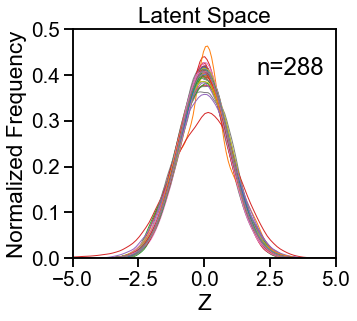

In [24]:
from sklearn.neighbors import KernelDensity
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Arial']})
plt.rcParams['font.size'] = 8
print(z.shape)
plt.figure(figsize=(5,4.5))
for i in range(len(z[0])):
    sns.kdeplot(z[:,i], lw=1)
plt.ylabel('Normalized Frequency')
plt.xlabel('Z')
plt.title('Latent Space')
plt.text(2,0.4,'n=%s'%(len(z[0])),fontsize=24)
plt.ylim(0,0.5)
plt.xlim(-5,5)
plt.tight_layout()
plt.savefig('images/kde.png',dpi=300,transparent=True)

================================== metal_node ==================================


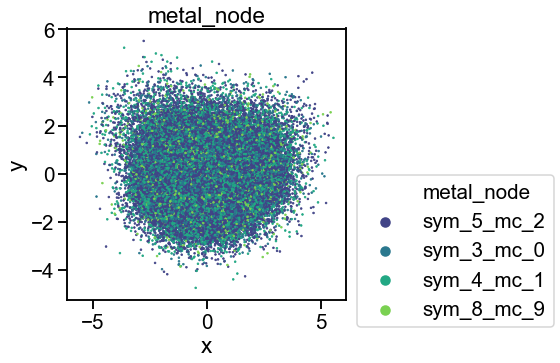

=================================== topology ===================================


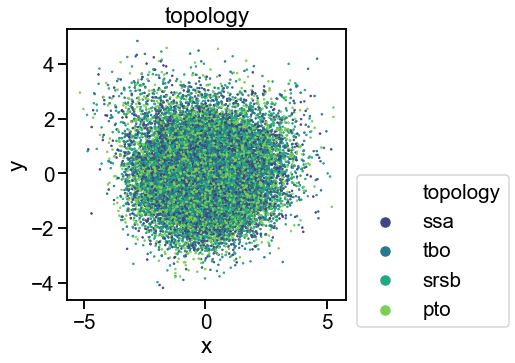

================================= organic_core =================================


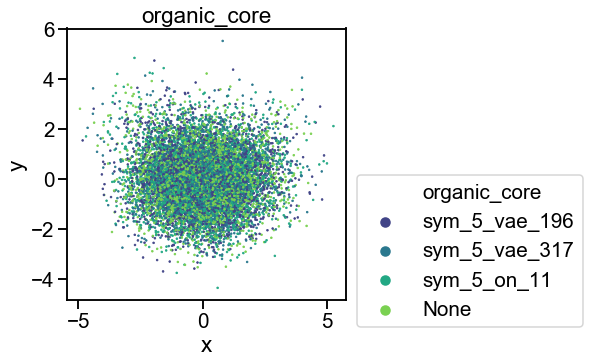

In [25]:
rc('font',**{'family':'sans-serif','sans-serif':['Arial']})
plt.rcParams['font.size'] = 8
top_k=4
tries = 0
#while tries < 5:
for index,col in enumerate(['metal_node','topology','organic_core']):
    print(header_str(col))
    plt.figure(figsize=(5,5))
    top_cat = z_mof_df[col].value_counts(sort=True,ascending=False).iloc[:top_k].index.tolist()
    #top_cat = random.sample(top_cat,4)
    #plt.scatter(z_mof_df['x'],z_mof_df['y'],c=z_mof_df[col], s=5,cmap=cmap,edgecolor=None)
    sns.scatterplot(x='x',y='y',hue=col,s=3,palette='viridis',data=z_mof_df[z_mof_df[col].isin(top_cat)],lw=1,edgecolor=None)
    plt.legend(bbox_to_anchor=(1, .5))
    plt.title(col)
    plt.savefig('images/%s-%s.png'%(col,tries),dpi=300,transparent=True)
    plt.show()
    #tries = tries + 1

In [26]:
sub_sample = 100000
src_data = prop_train
src_data = random.sample(src_data,min(len(src_data),sub_sample))
n = len(src_data)
batch_size=64
n_loops = int(np.ceil(n/batch_size))
z=[]
y=[]
for chunk in tqdm(chunked(src_data,batch_size),total=n_loops, desc='Generating predictions'):
    batch = model.tuples_to_tensors(chunk)
    y.extend(model.vocab_y.inverse_transform(batch['y']))
    z_tensor = model.inputs_to_z(batch['x'],batch['mof'])
    z.extend(z_tensor.cpu().numpy())
        
z = np.stack(z)
z_pca = PCA(2).fit_transform(z)
z_y_df = pd.DataFrame(y,columns=hparams.y_labels)
z_y_df['x']=z_pca[:,0]
z_y_df['y']=z_pca[:,1]
print(z.shape)
z_y_df.head()


(36795, 288)


lcd        pld   density      avf         avsa         agsa  \
0  22.592600  17.468109  0.193574  0.70041  1401.010010  7237.600098   
1  50.337112  47.552269  0.246492  0.67362  1163.660034  4720.890137   
2  17.930901  15.149700  0.260067  0.60391  1691.179932  6502.879883   
3  30.349159  26.702669  0.127431  0.81865   810.473999  6360.100098   
4  22.447510  18.654430  0.298311  0.61876  1444.599976  4842.589844   

   co2n2_co2_mol_kg  co2n2_n2_mol_kg  co2n2_selectivity  co2n2_heat_avg  ...  \
0          0.252021         0.355545           4.016705      -10.839380  ...   
1          0.645280         0.360090          10.154654      -16.108101  ...   
2          0.469408         0.359797           7.393011      -13.996040  ...   
3          0.485484         0.457378           6.014895      -12.867400  ...   
4          0.246370         0.228640           6.106100      -13.028379  ...   

   co2ch4_co2_mol_kg  co2ch4_ch4_mol_kg  co2ch4_selectivity  co2ch4_heat_avg  \
0           0.967610           3.586926            2.427842        -10.80487   
1           1.292239           3.633223            3.201055        -12.89046   
2           1.118080           3.615451            2.783254        -12.68778   
3           1.208044           3.568498            3.046770        -10.25216   
4           0.860634           2.446969            3.165430        -11.90395   

   co2ch4_heat_co2  co2ch4_heat_ch4  co2ch4_heat_molfrac   scscore         x  \
0       -16.074699         -9.58458            -10.96258  4.309125  0.097642   
1       -19.126810        -11.12334            -13.22335  3.935780  1.409141   
2       -17.617630        -11.19059            -12.70895  3.910479  0.917131   
3       -16.844240         -8.37012            -10.51842  3.910479 -0.122263   
4       -16.581619        -10.43736            -12.03926  3.622782 -1.234876   

          y  
0  2.093436  
1  3.539116  
2  1.624777  
3  2.662596  
4  0.271946  

[5 rows x 23 columns]

===================================== lcd ======================================


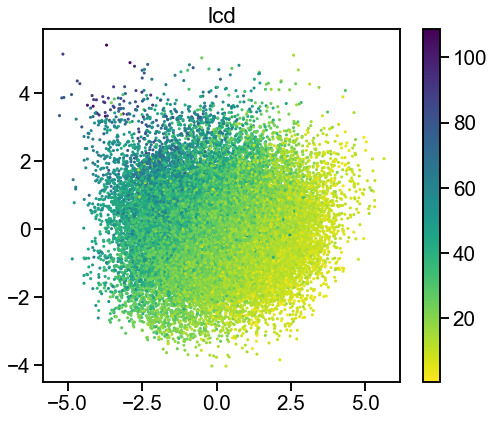

===================================== pld ======================================


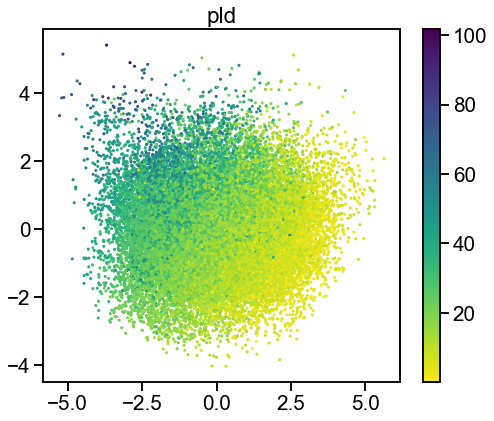

=================================== density ====================================


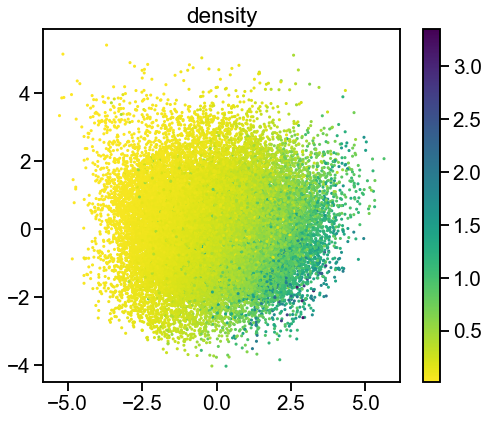

===================================== avf ======================================


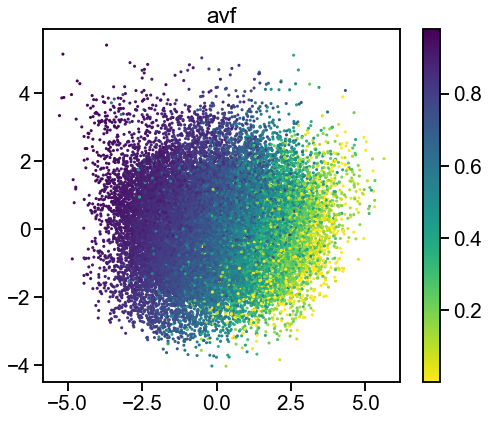

===================================== avsa =====================================


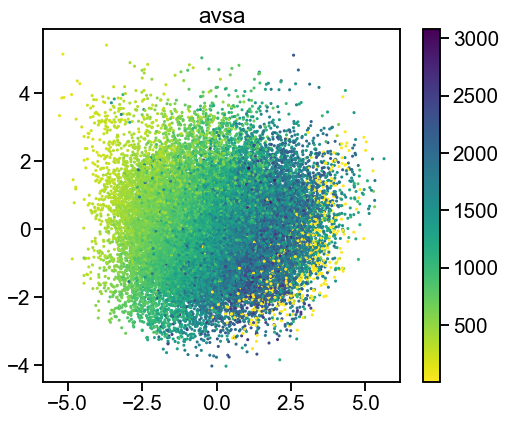

===================================== agsa =====================================


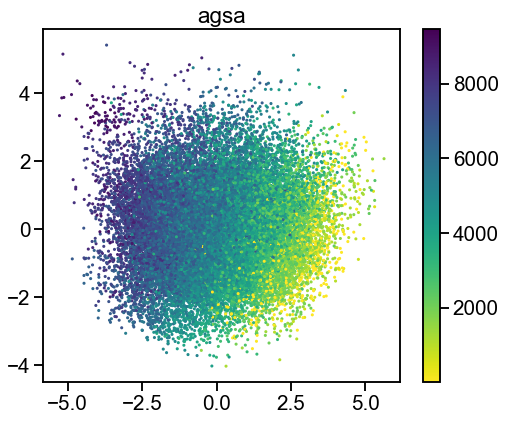

=============================== co2n2_co2_mol_kg ===============================


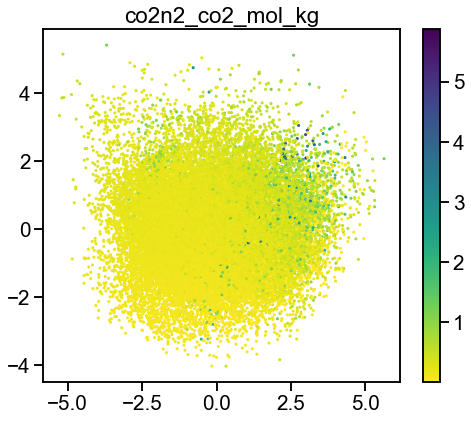

=============================== co2n2_n2_mol_kg ================================


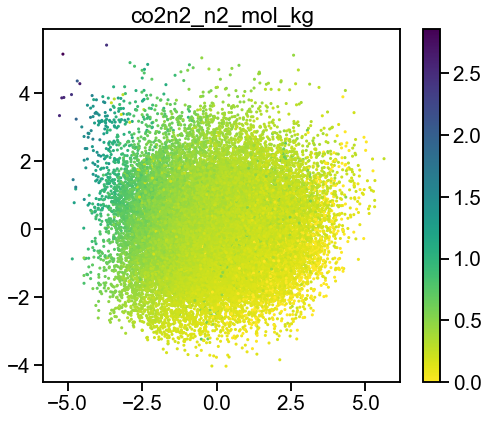

============================== co2n2_selectivity ===============================


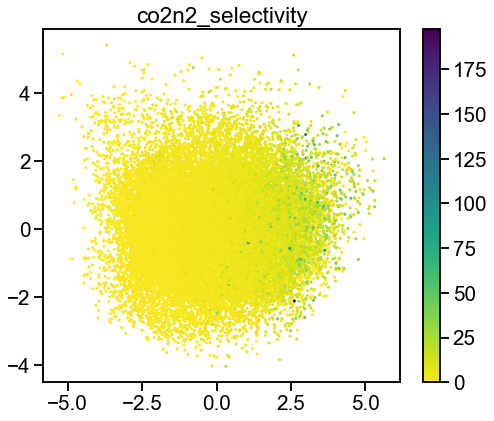

================================ co2n2_heat_avg ================================


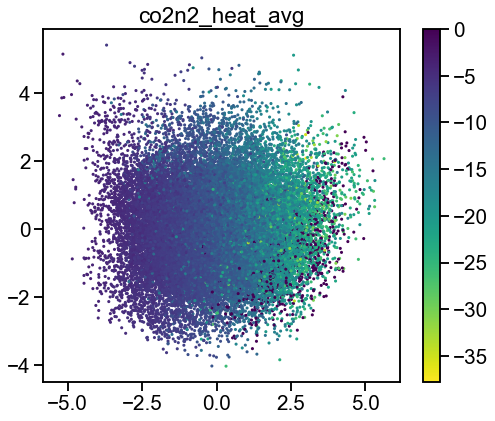

================================ co2n2_heat_co2 ================================


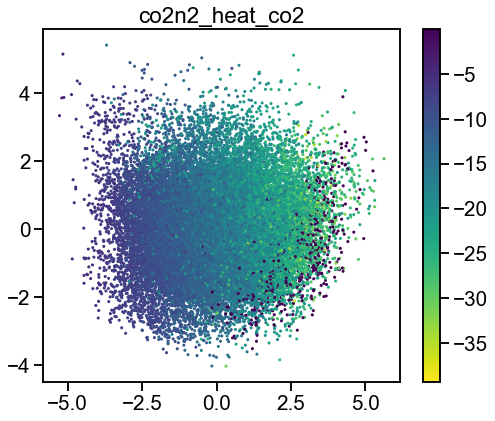

================================ co2n2_heat_n2 =================================


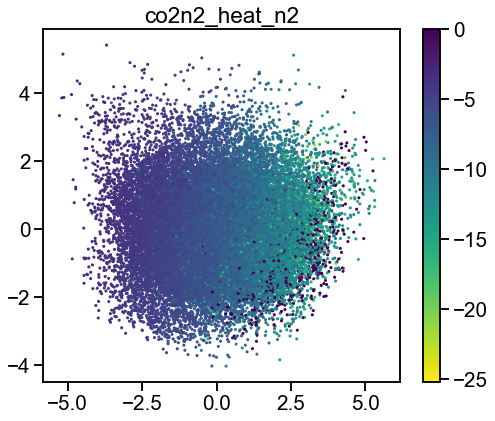

============================== co2n2_heat_molfrac ==============================


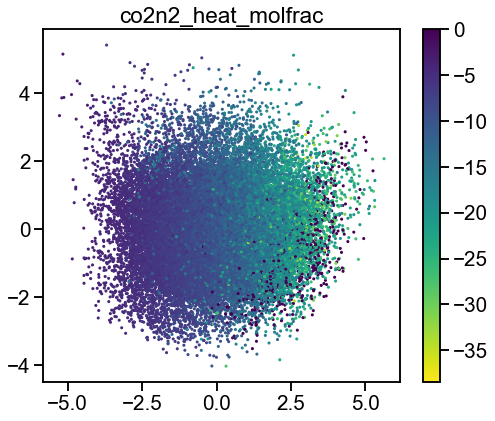

============================== co2ch4_co2_mol_kg ===============================


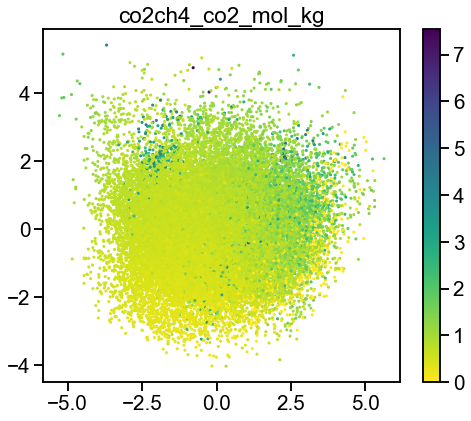

============================== co2ch4_ch4_mol_kg ===============================


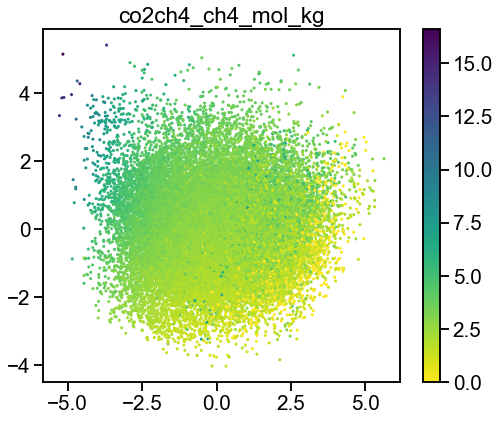

============================== co2ch4_selectivity ==============================


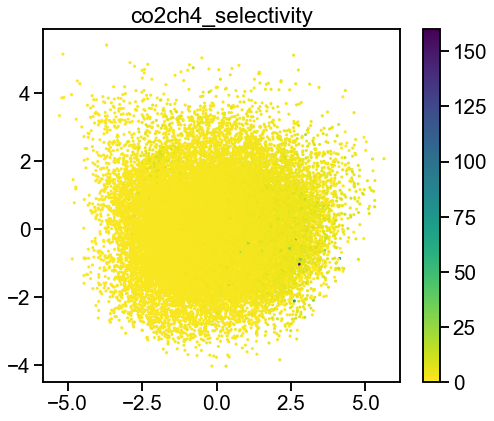

=============================== co2ch4_heat_avg ================================


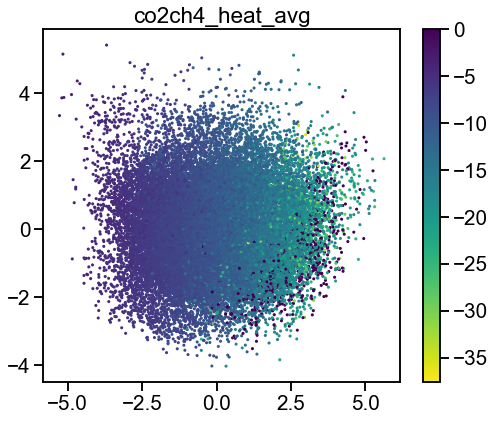

=============================== co2ch4_heat_co2 ================================


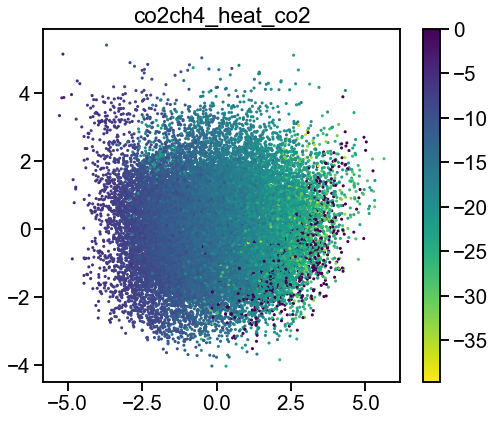

=============================== co2ch4_heat_ch4 ================================


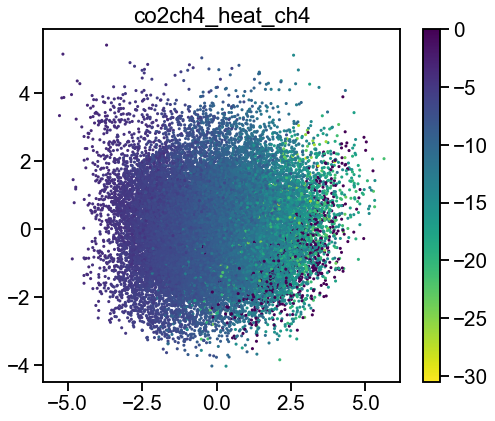

============================= co2ch4_heat_molfrac ==============================


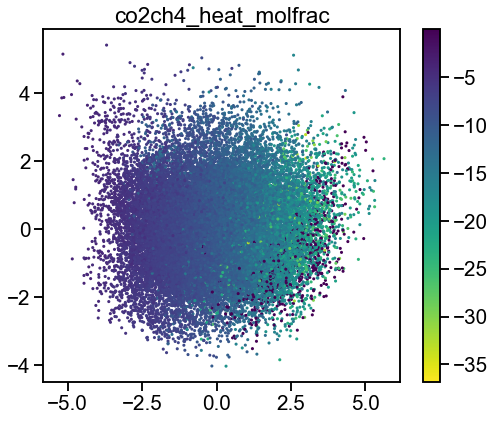

=================================== scscore ====================================


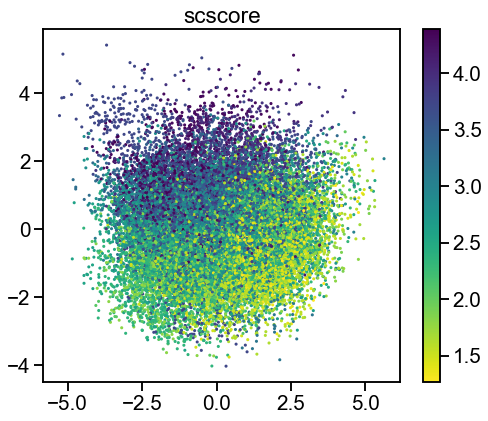

In [27]:
cmap='viridis_r'
for index,col in enumerate(hparams.y_labels):
    print(header_str(col))
    plt.figure(figsize=(8,6.5))
    scatter = plt.scatter(z_y_df['x'],z_y_df['y'],c=z_y_df[col], s=2.5,lw=1.5,cmap=cmap,edgecolor=None)
    plt.colorbar(scatter)
    #plt.legend(bbox_to_anchor=(1.5, .5))
    plt.title(col)
    plt.savefig('images/%s-%s.png'%(col,cmap),dpi=300,transparent=True)
    plt.show()